In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
from scipy.optimize import minimize
import torch
torch.manual_seed(0)
import torch.distributions as dist


def results(x,y):
#     print(x,y)
    if x>y:
        return 1
    elif x<y:
        return -1
    else:
        return 0
# epl_1718 = pd.read_csv("DataCLEANED.csv")
'''
1: Home Win
-1: Away WIn
0: Draw
'''
epl_1718 = pd.read_csv("cleaned_data.tsv", sep="\t")
epl_1718["Season"] = epl_1718["Season"].str.split("/", expand=True)[1]
epl_1718["Result"] = epl_1718.apply(lambda x: results(x["FTHG"], x["FTAG"]), axis=1)
epl_1718 = epl_1718[['HomeTeam','AwayTeam','FTHG','FTAG', 'Date', "Season", "Result"]]
epl_1718 = epl_1718.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1718.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,Result
0,Arsenal,Sunderland,4,1,Feb-14,14,1
1,Chelsea,Everton,1,0,Feb-14,14,1
2,Crystal Palace,Manchester United,0,2,Feb-14,14,-1
3,Manchester City,Stoke City,1,0,Feb-14,14,1
4,West Brom,Fulham,1,1,Feb-14,14,0


In [2]:
goal_model_data = pd.concat([epl_1718[['HomeTeam','AwayTeam','HomeGoals', 'Date']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1718[['AwayTeam','HomeTeam','AwayGoals', 'Date']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
display(goal_model_data.head())
display(goal_model_data.tail())

,team,opponent,goals,Date,home
0,Arsenal,Sunderland,4,Feb-14,1
1,Chelsea,Everton,1,Feb-14,1
2,Crystal Palace,Manchester United,0,Feb-14,1
3,Manchester City,Stoke City,1,Feb-14,1
4,West Brom,Fulham,1,Feb-14,1


,team,opponent,goals,Date,home
1293,Watford,Manchester United,0,May-18,0
1294,Chelsea,Newcastle United,0,May-18,0
1295,Manchester City,Southampton,1,May-18,0
1296,Stoke City,Swansea City,2,May-18,0
1297,Everton,West Ham United,1,May-18,0


In [3]:
teams = epl_1718.HomeTeam.unique()
teams.sort()
team_code = np.arange(epl_1718.HomeTeam.unique().shape[0])
team_dict = {}
for i in team_code:
    team_dict[teams[i]] = i
# l = torch.ones((epl_1718.HomeTeam.unique().shape[0],3), requires_grad = True) #home attack, home defense, away attack, away defense
l = torch.rand((epl_1718.HomeTeam.unique().shape[0],3), requires_grad = True)
# l_factor = 0.2*l
p = torch.tensor(0.01, requires_grad = True)
losses = []

In [4]:
def get_independence_factor(x,y, l, u, p):
#     print(x,y)
    if x==0 and y==0:
        t = 1-(l*u*p)
    elif x==0 and y==1:
        t = 1+(l*p)
    elif x==1 and y==0:
        t = 1+(u*p)
    elif x==1 and y==1:
        t = 1-p
    else:
        t = torch.tensor(1.0, requires_grad=True)
#     print("t: ",t)
    return(t)

In [5]:
def calc_loss(l, p, data, team_dict):
    loss = torch.tensor(0.0)
    for index, row in data.iterrows():
        lm = torch.exp(l[team_dict[row["HomeTeam"]],0]+l[team_dict[row["AwayTeam"]],1]+l[team_dict[row["HomeTeam"]],2])
        um = torch.exp(l[team_dict[row["AwayTeam"]],0]+l[team_dict[row["HomeTeam"]],1])
        x =  row["HomeGoals"]
        y =  row["AwayGoals"]
        p_lower = torch.max(torch.tensor([-1/lm, -1/um]))
        p_upper = torch.min(torch.tensor([1,1/(lm*um)]))
        if p< p_lower:
            p = p_lower
        elif p>p_upper:
            p = p_upper
#         print(p)
        t = torch.log(get_independence_factor(x,y, lm, um, p))   
#         print(t)
#         print("Loop: ",get_independence_factor(x,y, lm, um, p).item(), x, y, lm.item(), um.item(), loss.item())
#         if torch.isnan(lm):
#             print("Loop lm: ",get_independence_factor(x,y, lm, um, p).item(), x.item(), y.item(), lm.item(), um.item())
        
#         if torch.isnan(um):
#             print("Loop um: ",get_independence_factor(x,y, lm, um, p), x, y, lm, um)
        
#         if torch.isnan(t):
#             print("Loop t: ",get_independence_factor(x,y, lm, um, p), x, y, lm, um)
            
        home_prob = dist.Poisson(lm).log_prob(torch.tensor(x))
        away_prob = dist.Poisson(um).log_prob(torch.tensor(y))
        loss += t + home_prob + away_prob
    return(-loss)

print("LOSS: ",calc_loss(l, p, epl_1718, team_dict))

LOSS:  tensor(7875.1953, grad_fn=<NegBackward0>)


In [6]:
# optimizer = torch.optim.Adagrad([l,p], lr = 0.1)
# no_of_iter = 20
# no_of_teams = l.shape[0]
# for i in range(no_of_iter):
# #     l_cpy = l
#     sum_loss = torch.sqrt((1-((1/no_of_teams)*torch.sum(torch.exp(l[:,0]))))**2)
#     loss = calc_loss(l, p, epl_1718, team_dict) # +(0.05*sum_loss)
#     print("iter: %d, Loss: %f, sum loss: %f"%(i, loss, sum_loss))
#     losses.append(loss.item())
#     optimizer.zero_grad()
#     loss.backward(retain_graph=True)
#     optimizer.step()
# #     print(torch.sum(torch.exp(l[:,0])))
    

In [7]:
import matplotlib.pyplot as plt
# x = np.arange(len(losses))
# plt.plot(x, losses)
# plt.xlabel("Iter")
# plt.ylabel("Loss")
# plt.show()

In [8]:
# for i in team_dict.keys():
#     print(i,"\t",[float("{:.3f}".format(x.item())) for x in l[team_dict[i],:]])
# print("Rho: ", float("{:.3f}".format(p.item())))

In [9]:
def get_date_diff(d1,d2):
    months = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    m1_str, y1_str = d1.split('-')
    m1, y1 = months[m1_str.lower()], int(y1_str)
    m2_str, y2_str = d2.split('-')
    m2, y2 = months[m2_str.lower()], int(y2_str)
    diff = (y1-y2)+(m1-m2)/12.0
    return(diff)
#     print(m1, m2, y1, y2, diff)

# get_date_diff("12/2018", "01/2003")

In [10]:
display(epl_1718)

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,Result
0,Arsenal,Sunderland,4,1,Feb-14,14,1
1,Chelsea,Everton,1,0,Feb-14,14,1
2,Crystal Palace,Manchester United,0,2,Feb-14,14,-1
3,Manchester City,Stoke City,1,0,Feb-14,14,1
4,West Brom,Fulham,1,1,Feb-14,14,0
...,...,...,...,...,...,...,...
1293,Manchester United,Watford,1,0,May-18,18,1
1294,Newcastle United,Chelsea,3,0,May-18,18,1
1295,Southampton,Manchester City,0,1,May-18,18,-1
1296,Swansea City,Stoke City,1,2,May-18,18,-1


# Dixcon Choles Algorithm for score prediction with time decay


In [11]:
l_t = torch.rand((epl_1718.HomeTeam.unique().shape[0],3), requires_grad = True)
# l_factor = 0.2*l
p_t = torch.tensor(0.01, requires_grad = True)
e_t = torch.tensor(0.03, requires_grad = False)
losses_t = []
train_acc = []
test_acc = []

In [12]:
test_data = epl_1718[epl_1718["Season"]=="18"]
train = epl_1718[epl_1718["Season"]!="18"]
# display(train)
train["tdiff"] = train.apply(lambda row: get_date_diff(train['Date'].max(),row.Date), axis=1)
print(train['Date'].max(), train['Date'].min())
print(train.shape, test_data.shape)

Sep-16 Apr-14
(1021, 8) (277, 7)


/var/folders/r_/_2zhdj112pz03grjy7kklvhw0000gn/T/ipykernel_1354/1557530271.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["tdiff"] = train.apply(lambda row: get_date_diff(train['Date'].max(),row.Date), axis=1)


In [13]:
display(train.groupby("Result").size())

Result
-1    316
 0    235
 1    470
dtype: int64

In [14]:
def get_independence_factor_test(x,y, l, u, p):
#     print(x,y)
    t=[]
    for i in range(len(x)):
        if x[i]==0 and y[i]==0:
            a= 1-(l*u*p)
        elif x[i]==0 and y[i]==1:
            a= 1+(l*p)
        elif x[i]==1 and y[i]==0:
            a= 1+(u*p)
        elif x[i]==1 and y[i]==1:
            a= 1-p
        else:
            a= torch.tensor(1)
        t.append(a.item())
    return(t)


def predict_prob(l, p, home_team, away_team, home_goal, away_goal):
    lm = torch.exp(l[team_dict[home_team],0]+l[team_dict[away_team],1]+l[team_dict[home_team],2])
    um = torch.exp(l[team_dict[away_team],0]+l[team_dict[home_team],1])
    x =  home_goal
    y =  away_goal
    p_lower = torch.max(torch.tensor([-1/lm, -1/um]))
    p_upper = torch.min(torch.tensor([1,1/(lm*um)]))
    if p< p_lower:
        p = p_lower
    elif p>p_upper:
        p = p_upper
    t_e = [get_independence_factor_test(x[i],y[i], lm, um, p) for i in range(len(x))]
    t = torch.log(torch.tensor(np.array(t_e)))      
    home_prob = dist.Poisson(lm).log_prob(torch.tensor(x))
    away_prob = dist.Poisson(um).log_prob(torch.tensor(y))
    prob = t+home_prob+away_prob    
    return(prob)


def test(l, p, home_team, away_team, plot=False):
    xx, yy = np.meshgrid(np.arange(0,6,1), np.arange(0,6,1))
    tensor_zz = predict_prob(l, p, home_team, away_team, xx, yy)
    zz = tensor_zz.detach().numpy()
    i = np.unravel_index(np.argmax(zz), zz.shape)
    
    no_ndiag_ele = 0.5*((tensor_zz.shape[0]**2)-tensor_zz.shape[0])
    p_w = torch.sum(torch.triu(torch.exp(tensor_zz)))/no_ndiag_ele
    p_l = torch.sum(torch.tril(torch.exp(tensor_zz)))/no_ndiag_ele
    p_d = torch.sum(torch.diag(torch.exp(tensor_zz)))/tensor_zz.shape[0]
#     print(p_w, p_l, p_d)
    s = (p_w+p_l+p_d)
    p_w /= s
    p_l /= s
    p_d /= s
#     print(p_w, p_l, p_d)
    res = torch.argmax(torch.tensor((p_l, p_d, p_w)))-1
#     if res==1:
#         res_prob = p_w
#     elif res==-1:
#         res_prob = p_w
#     elif res==0:
#         res_prob = p_d
    if plot:
        print("P h win: %0.3f, P draw: %0.3f, P a w: %0.3f"%(p_w.item(), p_d.item(), p_l.item()))
        print("Highest probability Goal Summary\nHome Team %s: %d,\nAway Team %s: %d"%(home_team, xx[i], away_team, yy[i]))
        fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10, 5))
        cp1 = ax1.contourf(xx, yy, zz)
        fig.colorbar(cp1) # Add a colorbar to a plot
        ax1.set_title('Log Prob plot')
        ax1.set_xlabel('x (goals)')
        ax1.set_ylabel('y (goals)')

        cp2 = ax2.contourf(xx, yy, np.exp(zz))
        fig.colorbar(cp2) # Add a colorbar to a plot
        ax2.set_title('Prob plot')
        ax2.set_xlabel('x (goals)')
        ax2.set_ylabel('y (goals)')

        plt.show()
    return(res, (p_w, p_d, p_l), results(xx[i],yy[i]))

In [15]:
def calc_test_accuracy(l, p, data, home_team, away_team, method=1):
    pred = 0
#     with torch.no_grad:        
    for i, row in data.iterrows():
        res1, prob, res2 = test(l, p, row["HomeTeam"], row["AwayTeam"], plot=False)
        if method==1:
            pred += float(res1==row["Result"])
        elif method==0:
            pred += float(res2==row["Result"])
    return(pred/data.shape[0])    
        

In [16]:
def calc_loss_results(l, p, e, data, test_data, team_dict):
    loss = torch.tensor(0.0)
    train_pred = 0
    phw = 0
    paw = 0
    p_d = 0
    for index, row in data.iterrows():
        lm = torch.exp(l[team_dict[row["HomeTeam"]],0]+l[team_dict[row["AwayTeam"]],1]+l[team_dict[row["HomeTeam"]],2])
        um = torch.exp(l[team_dict[row["AwayTeam"]],0]+l[team_dict[row["HomeTeam"]],1])
        x =  row["HomeGoals"]
        y =  row["AwayGoals"]
        tdiff = row["tdiff"]
        p_lower = torch.max(torch.tensor([-1/lm, -1/um]))
        p_upper = torch.min(torch.tensor([1,1/(lm*um)]))
        if p< p_lower:
            p = p_lower
        elif p>p_upper:
            p = p_upper
        t = torch.log(get_independence_factor(x,y, lm, um, p))             
        home_prob = dist.Poisson(lm).log_prob(torch.tensor(x))
        away_prob = dist.Poisson(um).log_prob(torch.tensor(y))
        loss += torch.exp(-e*tdiff)*(t + home_prob + away_prob)
        
        res1, res_prob, res2 = test(l_t, p_t, row["HomeTeam"], row["AwayTeam"], plot=False)
        train_pred += float(res1==row["Result"])
        
        if row["Result"]==1:
            phw += res_prob[0]
        elif row["Result"]==-1:
            paw += res_prob[2]
        else:
            p_d += res_prob[1]    
        
#     loss = torch.log(phw)+torch.log(paw)+torch.log(p_d)
#     test_pred = calc_test_accuracy(l_t, p_t, test_data, row["HomeTeam"], row["AwayTeam"])
    train_pred /= data.shape[0]
    test_pred = 0
    
    return(-loss, train_pred, test_pred)
print("LOSS: ",calc_loss_results(l_t, p_t, e_t, train, test_data, team_dict))

LOSS:  (tensor(4276.6465, grad_fn=<NegBackward0>), 0.4622918707149853, 0)


In [17]:
def calc_loss(l, p, e, data, test_data, team_dict):
    loss = torch.tensor(0.0)
    train_pred = 0
    for index, row in data.iterrows():
        lm = torch.exp(l[team_dict[row["HomeTeam"]],0]+l[team_dict[row["AwayTeam"]],1]+l[team_dict[row["HomeTeam"]],2])
        um = torch.exp(l[team_dict[row["AwayTeam"]],0]+l[team_dict[row["HomeTeam"]],1])
        x =  row["HomeGoals"]
        y =  row["AwayGoals"]
        tdiff = row["tdiff"]
        p_lower = torch.max(torch.tensor([-1/lm, -1/um]))
        p_upper = torch.min(torch.tensor([1,1/(lm*um)]))
        if p< p_lower:
            p = p_lower
        elif p>p_upper:
            p = p_upper
        t = torch.log(get_independence_factor(x,y, lm, um, p))             
        home_prob = dist.Poisson(lm).log_prob(torch.tensor(x))
        away_prob = dist.Poisson(um).log_prob(torch.tensor(y))
        loss += torch.exp(-e*tdiff)*(t + home_prob + away_prob)
        train_pred += float(test(l_t, p_t, row["HomeTeam"], row["AwayTeam"], plot=False)[2]==row["Result"])
    test_pred = calc_test_accuracy(l_t, p_t, test_data, row["HomeTeam"], row["AwayTeam"])
    train_pred /= data.shape[0]
    
    return(-loss, train_pred, test_pred)

print("LOSS: ",calc_loss(l_t, p_t, e_t, train, test_data, team_dict))

LOSS:  (tensor(4276.6465, grad_fn=<NegBackward0>), 0.42703232125367285, 0.4332129963898917)


In [18]:
def run_train(l_t, p_t, e_t, train, test_data, team_dict, no_of_iter = 50, debug_msg=True):
    optimizer = torch.optim.Adagrad([l_t,p_t, e_t], lr = 0.1)
#     no_of_iter = 80
    no_of_teams = l_t.shape[0]
    for i in range(no_of_iter):
    #     l_cpy = l
        sum_loss = torch.sqrt((1-((1/no_of_teams)*torch.sum(torch.exp(l_t[:,0]))))**2)
        loss, train_accuracy, test_accuracy = calc_loss_results(l_t, p_t, e_t,train, test_data, team_dict) #+(0.05*sum_loss)

        if debug_msg:
            print("iter: %d, Loss: %0.3f, sum loss: %0.3f, train acc: %0.3f, test acc: %0.3f"%(i, loss, sum_loss, train_accuracy, test_accuracy))
        losses_t.append(loss.item())
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
#     print(torch.sum(torch.exp(l[:,0])))

run_train(l_t, p_t, e_t, train, test_data, team_dict, no_of_iter=80, debug_msg=True)   

iter: 0, Loss: 4276.646, sum loss: 0.676, train acc: 0.462, test acc: 0.000
iter: 1, Loss: 3598.876, sum loss: 0.531, train acc: 0.461, test acc: 0.000
iter: 2, Loss: 3356.651, sum loss: 0.474, train acc: 0.482, test acc: 0.000
iter: 3, Loss: 3232.865, sum loss: 0.434, train acc: 0.480, test acc: 0.000
iter: 4, Loss: 3155.048, sum loss: 0.406, train acc: 0.486, test acc: 0.000
iter: 5, Loss: 3101.532, sum loss: 0.383, train acc: 0.493, test acc: 0.000
iter: 6, Loss: 3062.468, sum loss: 0.365, train acc: 0.492, test acc: 0.000
iter: 7, Loss: 3032.709, sum loss: 0.350, train acc: 0.500, test acc: 0.000
iter: 8, Loss: 3009.303, sum loss: 0.337, train acc: 0.504, test acc: 0.000
iter: 9, Loss: 2990.417, sum loss: 0.326, train acc: 0.508, test acc: 0.000
iter: 10, Loss: 2974.870, sum loss: 0.317, train acc: 0.511, test acc: 0.000
iter: 11, Loss: 2961.863, sum loss: 0.309, train acc: 0.511, test acc: 0.000
iter: 12, Loss: 2950.833, sum loss: 0.302, train acc: 0.514, test acc: 0.000
iter: 13,

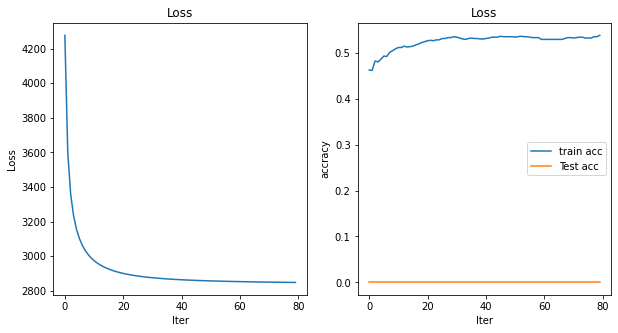

In [19]:
x = np.arange(len(losses_t))
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10, 5))
cp1 = ax1.plot(x, losses_t)
ax1.set_title('Loss')
ax1.set_xlabel('Iter')
ax1.set_ylabel('Loss')

ax2.plot(x, train_acc)
ax2.plot(x, test_acc)
ax2.set_title('Loss')
ax2.set_xlabel('Iter')
ax2.set_ylabel('accracy')
ax2.legend(("train acc", "Test acc"))
plt.show()

In [20]:
for i in team_dict.keys():
    print(i,"\t",[float("{:.3f}".format(np.exp(x.item()))) for x in l_t[team_dict[i],:]], "\t",[float("{:.3f}".format(x.item())) for x in l_t[team_dict[i],:]])
print("Rho: ", float("{:.3f}".format(p_t.item())))
print("e: ", float("{:.3f}".format(e_t.item())))

Arsenal 	 [1.651, 0.851, 1.205] 	 [0.501, -0.162, 0.187]
Aston Villa 	 [0.778, 1.32, 1.078] 	 [-0.251, 0.278, 0.075]
Bournemouth 	 [1.132, 1.386, 1.396] 	 [0.124, 0.326, 0.333]
Brighton 	 [1.988, 1.005, 1.192] 	 [0.687, 0.005, 0.176]
Burnley 	 [0.99, 1.081, 0.951] 	 [-0.01, 0.078, -0.05]
Cardiff 	 [1.012, 1.141, 1.89] 	 [0.012, 0.132, 0.637]
Chelsea 	 [1.556, 0.786, 1.304] 	 [0.442, -0.241, 0.266]
Crystal Palace 	 [1.281, 1.099, 0.916] 	 [0.248, 0.094, -0.087]
Everton 	 [1.225, 0.941, 1.47] 	 [0.203, -0.061, 0.385]
Fulham 	 [1.106, 1.569, 1.26] 	 [0.101, 0.45, 0.231]
Huddersfield 	 [2.323, 1.082, 1.456] 	 [0.843, 0.078, 0.376]
Hull City 	 [0.836, 1.363, 1.228] 	 [-0.179, 0.31, 0.206]
Leicester City 	 [1.298, 1.031, 1.249] 	 [0.261, 0.03, 0.222]
Liverpool 	 [1.581, 0.98, 1.09] 	 [0.458, -0.021, 0.087]
Manchester City 	 [1.797, 0.803, 1.272] 	 [0.586, -0.219, 0.241]
Manchester United 	 [1.25, 0.748, 1.318] 	 [0.223, -0.29, 0.276]
Middlesbrough 	 [0.609, 0.985, 1.447] 	 [-0.496, -0.015, 0

In [21]:
def simulate_match(l_t, p_t, e_t, train, test_data, team_dict):
    train_local = pd.DataFrame(columns = train.columns)
    acc = 0
    match = 0
#     display(train_local.tail(5))
    for i, row in test_data.iterrows():
        res1, prob, res2 = test(l_t, p_t, row["HomeTeam"], row["AwayTeam"], plot=False)
        match +=1
        if res1==row["Result"]:
            acc += 1     
        
        train_local.loc[i] = row
        train_local.loc[i,"tdiff"] = 0.5
        run_train(l_t, p_t, e_t, train_local, test_data, team_dict, no_of_iter = 20, debug_msg=False)
        print(match," test_pred: ", acc/match, "acc: ", acc, "match: ", match)
    display(train_local.tail(5))
    print(train_local.shape)

simulate_match(l_t, p_t, e_t, train, test_data, team_dict)

1  test_pred:  1.0 acc:  1 match:  1
2  test_pred:  0.5 acc:  1 match:  2
3  test_pred:  0.3333333333333333 acc:  1 match:  3
4  test_pred:  0.5 acc:  2 match:  4
5  test_pred:  0.4 acc:  2 match:  5
6  test_pred:  0.3333333333333333 acc:  2 match:  6
7  test_pred:  0.42857142857142855 acc:  3 match:  7
8  test_pred:  0.5 acc:  4 match:  8
9  test_pred:  0.5555555555555556 acc:  5 match:  9
10  test_pred:  0.6 acc:  6 match:  10
11  test_pred:  0.5454545454545454 acc:  6 match:  11
12  test_pred:  0.5833333333333334 acc:  7 match:  12
13  test_pred:  0.6153846153846154 acc:  8 match:  13
14  test_pred:  0.5714285714285714 acc:  8 match:  14
15  test_pred:  0.5333333333333333 acc:  8 match:  15
16  test_pred:  0.5 acc:  8 match:  16
17  test_pred:  0.47058823529411764 acc:  8 match:  17
18  test_pred:  0.5 acc:  9 match:  18
19  test_pred:  0.5263157894736842 acc:  10 match:  19
20  test_pred:  0.5 acc:  10 match:  20
21  test_pred:  0.5238095238095238 acc:  11 match:  21
22  test_pred:

159  test_pred:  0.49056603773584906 acc:  78 match:  159
160  test_pred:  0.4875 acc:  78 match:  160
161  test_pred:  0.484472049689441 acc:  78 match:  161
162  test_pred:  0.4876543209876543 acc:  79 match:  162
163  test_pred:  0.48466257668711654 acc:  79 match:  163
164  test_pred:  0.4817073170731707 acc:  79 match:  164
165  test_pred:  0.47878787878787876 acc:  79 match:  165
166  test_pred:  0.4759036144578313 acc:  79 match:  166
167  test_pred:  0.47904191616766467 acc:  80 match:  167
168  test_pred:  0.48214285714285715 acc:  81 match:  168
169  test_pred:  0.48520710059171596 acc:  82 match:  169
170  test_pred:  0.4823529411764706 acc:  82 match:  170
171  test_pred:  0.4853801169590643 acc:  83 match:  171
172  test_pred:  0.4883720930232558 acc:  84 match:  172
173  test_pred:  0.48554913294797686 acc:  84 match:  173
174  test_pred:  0.4827586206896552 acc:  84 match:  174
175  test_pred:  0.48 acc:  84 match:  175
176  test_pred:  0.48295454545454547 acc:  85 match

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,Result,tdiff
1293,Manchester United,Watford,1,0,May-18,18,1,0.5
1294,Newcastle United,Chelsea,3,0,May-18,18,1,0.5
1295,Southampton,Manchester City,0,1,May-18,18,-1,0.5
1296,Swansea City,Stoke City,1,2,May-18,18,-1,0.5
1297,West Ham United,Everton,3,1,May-18,18,1,0.5


(277, 8)


In [22]:
def get_test_accuracy(l_t, p_t, e_t, train, test_data, team_dict):
    train_local = pd.DataFrame(columns = train.columns)
    acc = 0
    match = 0
#     display(train_local.tail(5))
    for i, row in test_data.iterrows():
        res1, prob, res2 = test(l_t, p_t, row["HomeTeam"], row["AwayTeam"], plot=False)
        match +=1
        if res1==row["Result"]:
            acc += 1     
        
        train_local.loc[i] = row
        train_local.loc[i,"tdiff"] = 0.5
        print(match," test_pred: ", acc/match, "acc: ", acc, "match: ", match)
    display(train_local.tail(5))
    print(train_local.shape)

get_test_accuracy(l_t, p_t, e_t, train, test_data, team_dict)

1  test_pred:  1.0 acc:  1 match:  1
2  test_pred:  1.0 acc:  2 match:  2
3  test_pred:  0.6666666666666666 acc:  2 match:  3
4  test_pred:  0.75 acc:  3 match:  4
5  test_pred:  0.6 acc:  3 match:  5
6  test_pred:  0.5 acc:  3 match:  6
7  test_pred:  0.5714285714285714 acc:  4 match:  7
8  test_pred:  0.625 acc:  5 match:  8
9  test_pred:  0.6666666666666666 acc:  6 match:  9
10  test_pred:  0.6 acc:  6 match:  10
11  test_pred:  0.5454545454545454 acc:  6 match:  11
12  test_pred:  0.5833333333333334 acc:  7 match:  12
13  test_pred:  0.6153846153846154 acc:  8 match:  13
14  test_pred:  0.6428571428571429 acc:  9 match:  14
15  test_pred:  0.6 acc:  9 match:  15
16  test_pred:  0.625 acc:  10 match:  16
17  test_pred:  0.5882352941176471 acc:  10 match:  17
18  test_pred:  0.5555555555555556 acc:  10 match:  18
19  test_pred:  0.5789473684210527 acc:  11 match:  19
20  test_pred:  0.55 acc:  11 match:  20
21  test_pred:  0.5714285714285714 acc:  12 match:  21
22  test_pred:  0.5909

230  test_pred:  0.5956521739130435 acc:  137 match:  230
231  test_pred:  0.5930735930735931 acc:  137 match:  231
232  test_pred:  0.5948275862068966 acc:  138 match:  232
233  test_pred:  0.5965665236051502 acc:  139 match:  233
234  test_pred:  0.594017094017094 acc:  139 match:  234
235  test_pred:  0.5957446808510638 acc:  140 match:  235
236  test_pred:  0.5932203389830508 acc:  140 match:  236
237  test_pred:  0.5907172995780591 acc:  140 match:  237
238  test_pred:  0.592436974789916 acc:  141 match:  238
239  test_pred:  0.5941422594142259 acc:  142 match:  239
240  test_pred:  0.5958333333333333 acc:  143 match:  240
241  test_pred:  0.5933609958506224 acc:  143 match:  241
242  test_pred:  0.5950413223140496 acc:  144 match:  242
243  test_pred:  0.5925925925925926 acc:  144 match:  243
244  test_pred:  0.5942622950819673 acc:  145 match:  244
245  test_pred:  0.5918367346938775 acc:  145 match:  245
246  test_pred:  0.5894308943089431 acc:  145 match:  246
247  test_pred: 

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Date,Season,Result,tdiff
1293,Manchester United,Watford,1,0,May-18,18,1,0.5
1294,Newcastle United,Chelsea,3,0,May-18,18,1,0.5
1295,Southampton,Manchester City,0,1,May-18,18,-1,0.5
1296,Swansea City,Stoke City,1,2,May-18,18,-1,0.5
1297,West Ham United,Everton,3,1,May-18,18,1,0.5


(277, 8)


In [23]:
for i in team_dict.keys():
    print(i,"\t",[float("{:.3f}".format(np.exp(x.item()))) for x in l_t[team_dict[i],:]], "\t",[float("{:.3f}".format(x.item())) for x in l_t[team_dict[i],:]])
print("Rho: ", float("{:.3f}".format(p_t.item())))
print("e: ", float("{:.3f}".format(e_t.item())))

Arsenal 	 [0.877, 1.141, 2.867] 	 [-0.131, 0.132, 1.053]
Aston Villa 	 [0.778, 1.32, 1.078] 	 [-0.251, 0.278, 0.075]
Bournemouth 	 [0.74, 1.382, 1.262] 	 [-0.301, 0.323, 0.233]
Brighton 	 [0.273, 1.27, 4.308] 	 [-1.298, 0.239, 1.46]
Burnley 	 [0.792, 0.853, 0.893] 	 [-0.233, -0.159, -0.113]
Cardiff 	 [1.012, 1.141, 1.89] 	 [0.012, 0.132, 0.637]
Chelsea 	 [1.206, 0.82, 1.208] 	 [0.187, -0.198, 0.189]
Crystal Palace 	 [0.641, 1.209, 2.097] 	 [-0.445, 0.19, 0.74]
Everton 	 [0.791, 1.432, 1.394] 	 [-0.235, 0.359, 0.333]
Fulham 	 [1.106, 1.569, 1.26] 	 [0.101, 0.45, 0.231]
Huddersfield 	 [0.0, 0.978, 1390208.395] 	 [-14.052, -0.022, 14.145]
Hull City 	 [0.836, 1.363, 1.228] 	 [-0.179, 0.31, 0.206]
Leicester City 	 [1.232, 1.365, 0.781] 	 [0.209, 0.311, -0.247]
Liverpool 	 [1.607, 0.894, 1.202] 	 [0.474, -0.112, 0.184]
Manchester City 	 [1.905, 0.729, 1.687] 	 [0.644, -0.316, 0.523]
Manchester United 	 [1.529, 0.582, 1.112] 	 [0.425, -0.541, 0.106]
Middlesbrough 	 [0.609, 0.985, 1.447] 	 [-0

P h win: 0.784, P draw: 0.118, P a w: 0.098
Highest probability Goal Summary
Home Team Arsenal: 3,
Away Team West Brom: 0


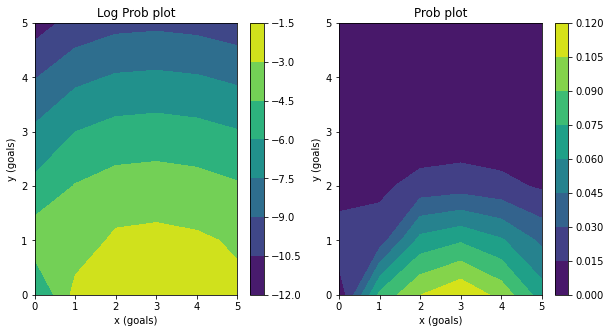

P h win: 0.349, P draw: 0.270, P a w: 0.381
Highest probability Goal Summary
Home Team West Brom: 0,
Away Team Arsenal: 1


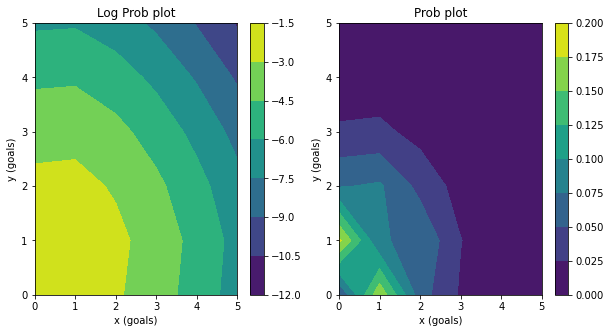

(tensor(-1),
 (tensor(0.3492, dtype=torch.float64, grad_fn=<DivBackward0>),
  tensor(0.2698, dtype=torch.float64, grad_fn=<DivBackward0>),
  tensor(0.3810, dtype=torch.float64, grad_fn=<DivBackward0>)),
 -1)

In [24]:
test(l_t, p_t, "Arsenal","West Brom", plot=True)
test(l_t, p_t, "West Brom","Arsenal", plot=True)